In [4]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


Binary görüntü boyutu: (512, 512)
Binary görüntü tipi: uint8


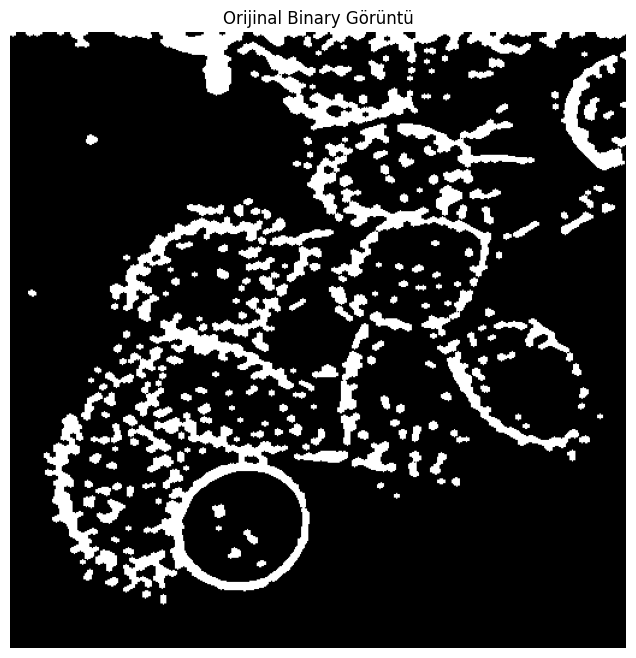

In [5]:
# Görüntüyü yükle
input_path = "hela_dataset-train-01/t009_processed.tif"
output_path = "hela_dataset-train-01/t009_processed.tif"

# TIF dosyasını oku (binary görüntü)
binary = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

if binary is None:
    print(f"Hata: {input_path} dosyası okunamadı!")
else:
    print(f"Binary görüntü boyutu: {binary.shape}")
    print(f"Binary görüntü tipi: {binary.dtype}")
    
    # Orijinal görüntüyü göster
    plt.figure(figsize=(8, 8))
    plt.imshow(binary, cmap='gray')
    plt.title('Orijinal Binary Görüntü')
    plt.axis('off')
    plt.show()


Closing işlemi tamamlandı
Closing öncesi - Beyaz: 40294, Siyah: 221850
Closing sonrası - Beyaz: 40927, Siyah: 221217


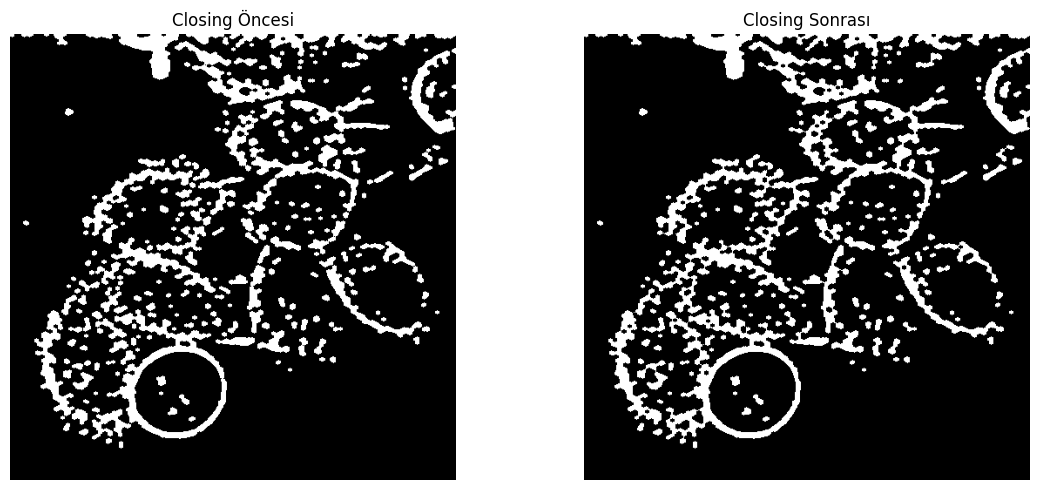

In [6]:
# Morphological işlemler için kernel oluştur
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# Alternatif kernel seçenekleri:
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

# 1. Closing işlemi: Dilation + Erosion
# Küçük delikleri kapatır ve nesneleri birleştirir
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
print(f"Closing işlemi tamamlandı")
print(f"Closing öncesi - Beyaz: {np.sum(binary == 255)}, Siyah: {np.sum(binary == 0)}")
print(f"Closing sonrası - Beyaz: {np.sum(closed == 255)}, Siyah: {np.sum(closed == 0)}")

# Closing sonucunu göster
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(binary, cmap='gray')
plt.title('Closing Öncesi')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(closed, cmap='gray')
plt.title('Closing Sonrası')
plt.axis('off')
plt.tight_layout()
plt.show()


Opening işlemi tamamlandı
Opening sonrası - Beyaz: 40294, Siyah: 221850


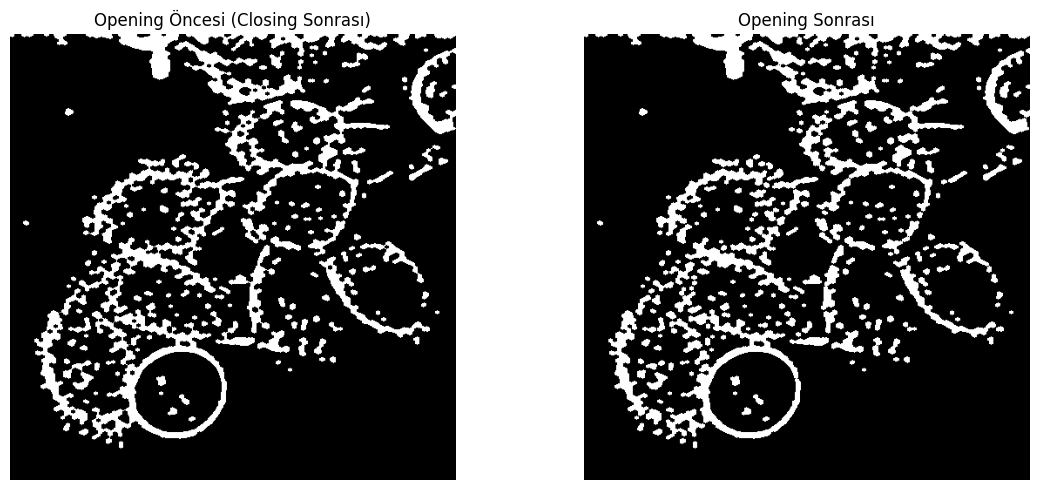

In [7]:
# 2. Opening işlemi: Erosion + Dilation
# Küçük gürültüleri ve ince çıkıntıları temizler
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
print(f"Opening işlemi tamamlandı")
print(f"Opening sonrası - Beyaz: {np.sum(opened == 255)}, Siyah: {np.sum(opened == 0)}")

# Opening sonucunu göster
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(closed, cmap='gray')
plt.title('Opening Öncesi (Closing Sonrası)')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(opened, cmap='gray')
plt.title('Opening Sonrası')
plt.axis('off')
plt.tight_layout()
plt.show()



Connected Components Analizi:
Toplam bileşen sayısı (arka plan dahil): 264
Gerçek nesne sayısı: 263

Küçük bileşen temizleme:
Eşik değeri: 100 piksel
Korunan bileşen sayısı: 64
Silinen bileşen sayısı: 199
Filtreleme öncesi - Beyaz: 40294, Siyah: 221850
Filtreleme sonrası - Beyaz: 32384, Siyah: 229760

Küçük bileşenler temizlenmiş görüntü kaydedildi: hela_dataset-train-01/t009_processed.tif


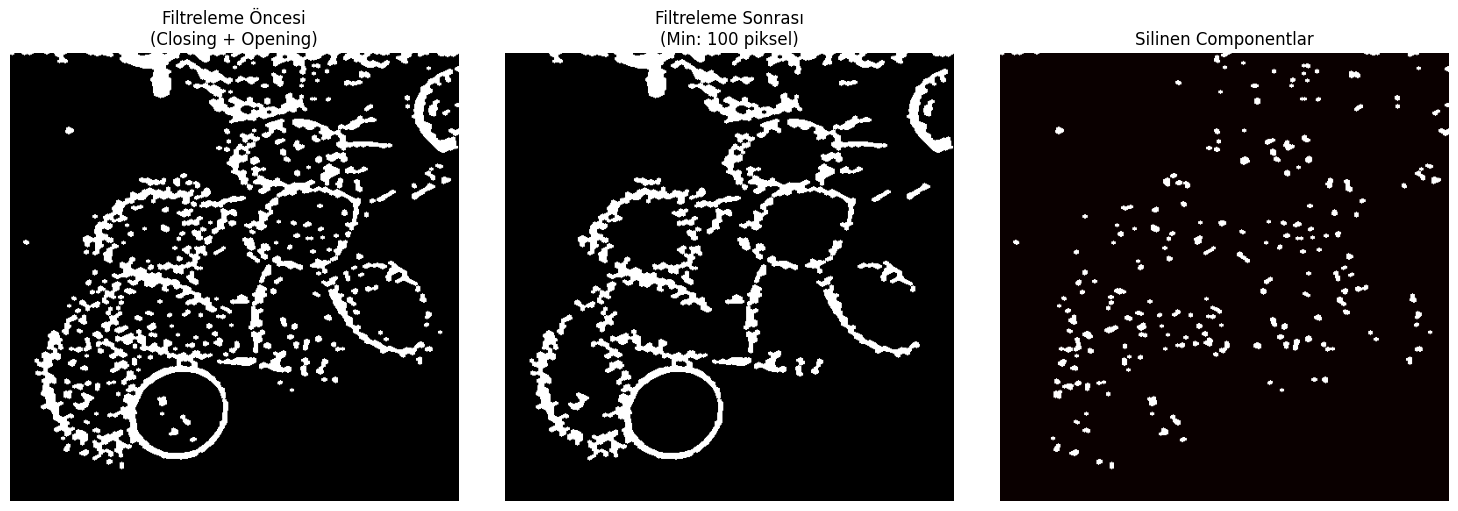

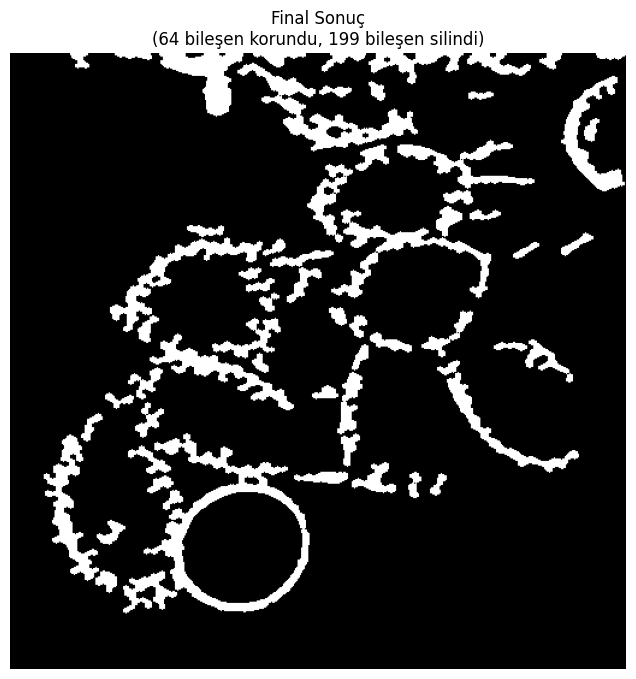

In [9]:
# Connected Components Analizi
# Bileşenleri analiz et (stats ile alan bilgisi al)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)

print(f"\nConnected Components Analizi:")
print(f"Toplam bileşen sayısı (arka plan dahil): {num_labels}")
print(f"Gerçek nesne sayısı: {num_labels - 1}")  # 0 = arka plan

# Küçük bileşenleri silmek için eşik değeri (piksel sayısı)
min_pixel_size = 100  # Bu değeri ihtiyaca göre ayarlayabilirsiniz

# Yeni görüntü oluştur (sadece büyük bileşenler kalacak)
filtered = np.zeros_like(opened)

# Her bileşeni kontrol et (0 = arka plan, atla)
removed_count = 0
kept_count = 0

for label_id in range(1, num_labels):  # 0'ı atla (arka plan)
    area = stats[label_id, cv2.CC_STAT_AREA]
    
    if area >= min_pixel_size:
        # Büyük bileşeni koru
        filtered[labels == label_id] = 255
        kept_count += 1
    else:
        # Küçük bileşeni sil
        removed_count += 1

print(f"\nKüçük bileşen temizleme:")
print(f"Eşik değeri: {min_pixel_size} piksel")
print(f"Korunan bileşen sayısı: {kept_count}")
print(f"Silinen bileşen sayısı: {removed_count}")
print(f"Filtreleme öncesi - Beyaz: {np.sum(opened == 255)}, Siyah: {np.sum(opened == 0)}")
print(f"Filtreleme sonrası - Beyaz: {np.sum(filtered == 255)}, Siyah: {np.sum(filtered == 0)}")

# Sonucu kaydet
cv2.imwrite(output_path, filtered)
print(f"\nKüçük bileşenler temizlenmiş görüntü kaydedildi: {output_path}")

# Sonuçları göster
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(opened, cmap='gray')
plt.title('Filtreleme Öncesi\n(Closing + Opening)')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(filtered, cmap='gray')
plt.title(f'Filtreleme Sonrası\n(Min: {min_pixel_size} piksel)')
plt.axis('off')
plt.subplot(1, 3, 3)
# Fark görüntüsü (silinen componentları göster)
diff = opened.copy()
diff[filtered == 255] = 0  # Korunanları siyah yap
plt.imshow(diff, cmap='hot')
plt.title('Silinen Componentlar')
plt.axis('off')
plt.tight_layout()
plt.show()

# Final sonucu göster
plt.figure(figsize=(8, 8))
plt.imshow(filtered, cmap='gray')
plt.title(f'Final Sonuç\n({kept_count} bileşen korundu, {removed_count} bileşen silindi)')
plt.axis('off')
plt.show()


In [ ]:
# Opening işlemi: Erosion + Dilation
# Küçük gürültüleri ve ince çıkıntıları temizler
opened_final = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
print(f"Opening işlemi tamamlandı")
print(f"Opening öncesi - Beyaz: {np.sum(filtered == 255)}, Siyah: {np.sum(filtered == 0)}")
print(f"Opening sonrası - Beyaz: {np.sum(opened_final == 255)}, Siyah: {np.sum(opened_final == 0)}")

# Opening sonucunu göster
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(filtered, cmap='gray')
plt.title('Opening Öncesi\n(Connected Components Filtreleme Sonrası)')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(opened_final, cmap='gray')
plt.title('Opening Sonrası')
plt.axis('off')
plt.tight_layout()
plt.show()

# Final sonucu kaydet
cv2.imwrite(output_path, opened_final)
print(f"\nFinal görüntü kaydedildi: {output_path}")

# Final sonucu göster
plt.figure(figsize=(8, 8))
plt.imshow(opened_final, cmap='gray')
plt.title('Final Sonuç (Opening Uygulanmış)')
plt.axis('off')
plt.show()
